In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from numpy import *
import statsmodels.api as sm
import statsmodels.stats.diagnostic
import matplotlib.pyplot as plt
%load_ext blackcellmagic
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.stats.outliers_influence import variance_inflation_factor
#如遇中文显示问题可加入以下代码
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
from statsmodels.tsa.vector_ar.vecm import coint_johansen

D:\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
D:\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## 导入数据时间+主题分

In [2]:
# import time
df1= pd.read_csv(
    "./data/df_japan.csv",
    header=None,
    encoding="gbk",
    names=["time", "none", "catagory", "title", "content"],
)

# import sparse matrix
lda_score = pd.read_csv("./data/lda_7.csv")


### 处理时间口径为月份均值

In [4]:
time_column = pd.to_datetime(df1['time'])
time_column = time_column.dt.to_period("M").dt.to_timestamp()
df2 = pd.concat([time_column, lda_score], axis=1)
df3 = df2.groupby(['time']).agg('mean')
df3.shape

(880, 7)

### 给主题命名，删掉奥运会主题

In [5]:
new_col=["中日双边合作",
    "中美经贸带动世界经济发展",
    "中国社会发展",
    "中日企业合作",
    "中日历史与抗战认识问题",
    "世界和平和国际安全",
    "中国参加奥运会"]
df3.columns=new_col
df4=df3.drop(["中国参加奥运会"],axis=1)
df4.head()

,中日双边合作,中美经贸带动世界经济发展,中国社会发展,中日企业合作,中日历史与抗战认识问题,世界和平和国际安全
time,,,,,,
1946-05-01,0.220377,0.035148,0.020722,0.082530,0.442255,0.198229
1946-06-01,0.105639,0.026655,0.025296,0.101992,0.474997,0.264438
1946-07-01,0.103348,0.022192,0.019548,0.041566,0.495220,0.316815
1946-08-01,0.106302,0.023587,0.035205,0.069731,0.466334,0.296444
1946-09-01,0.097083,0.031750,0.016611,0.058010,0.592563,0.202176


## 单位根检验

In [10]:
t_list = []
name_list = []
p_list = []
for i in df4.columns:
    name_list.append(i)
    test_output = list(adfuller(df4.loc[:,i]))
    t_list.append(test_output[0])
    p_list.append(test_output[1])
    
pd.DataFrame({'name': name_list, 't_value': t_list, 'p_value': p_list})

,name,t_value,p_value
0,中日双边合作,-2.533898,0.107443
1,中美经贸带动世界经济发展,-0.929277,0.778178
2,中国社会发展,-1.480002,0.543380
3,中日企业合作,-1.442794,0.561597
4,中日历史与抗战认识问题,-5.181652,0.000010
5,世界和平和国际安全,-1.332795,0.614038


### 只有‘中日历史与抗战认识问题’是平稳的，因此其余5个做一阶差分

In [69]:
#取一阶差分
df5=df4.drop(["中日历史与抗战认识问题"],axis=1)
df6=df5.diff(periods=1).dropna()
t_list1 = []
name_list1 = []
p_list1 = []
#df5.head()
#单位根检验通过
for i in df6.columns:
    name_list1.append(i)
    test_output = list(adfuller(df6.loc[:, i]))
    t_list1.append(test_output[0])
    p_list1.append(test_output[1])
    
pd.DataFrame({'name': name_list1, 't_value': t_list1, 'p_value': p_list1})


,name,t_value,p_value
0,中日双边合作,-9.458432,4.420153e-16
1,中美经贸带动世界经济发展,-9.247965,1.519230e-15
2,中国社会发展,-12.142484,1.638890e-22
3,中日企业合作,-14.963951,1.227858e-27
4,世界和平和国际安全,-13.622633,1.784571e-25


### 一阶差分后平稳，因此做协作检验

In [70]:
'''
#约翰逊协整检验
h0:有0个协整关系
h1:有m个协整关系
以最大特征值对应的特征向量作做为整个系统的协整，默认第一个

'''
# 参数设置常数项滞后一阶
coin1=coint_johansen(df6,0,1) #  有截距项
coin2=coint_johansen(df6,-1,1) # 无确定趋势
coin3=coint_johansen(df6,1,1) # 有确定趋势

In [71]:
# 定义一个函数减少重复值
def SUM(coin):
    EIG = pd.DataFrame(coin.eig,index=df6.columns,columns=['Eigenvalue'])
    PV = pd.DataFrame(coin.cvt,index=df6.columns,columns=['10%','5%','1%'])
    LR = pd.DataFrame(coin.lr2,index=df6.columns,columns=['LR'])
    SUM_tol = pd.concat([EIG,LR,PV],axis=1)
    return SUM_tol

### 查看协作检验的结果

In [72]:
SUM(coin1)

,Eigenvalue,LR,10%,5%,1%
中日双边合作,0.578246,757.143196,65.8202,69.8189,77.8202
中美经贸带动世界经济发展,0.559907,719.815149,44.4929,47.8545,54.6815
中国社会发展,0.521854,647.085475,27.0669,29.7961,35.4628
中日企业合作,0.479037,571.870130,13.4294,15.4943,19.9349
世界和平和国际安全,0.472939,561.665572,2.7055,3.8415,6.6349


In [73]:
SUM(coin2)

,Eigenvalue,LR,10%,5%,1%
中日双边合作,0.578202,757.051086,56.2839,60.0627,67.6367
中美经贸带动世界经济发展,0.559900,719.800636,37.0339,40.1749,46.5716
中国社会发展,0.521842,647.062352,21.7781,24.2761,29.5147
中日企业合作,0.478999,571.807608,10.4741,12.3212,16.3640
世界和平和国际安全,0.472918,561.629392,2.9762,4.1296,6.9406


In [74]:
SUM(coin3)

,Eigenvalue,LR,10%,5%,1%
中日双边合作,0.578283,757.219165,75.1027,79.3422,87.7748
中美经贸带动世界经济发展,0.559931,719.862689,51.6492,55.2459,62.5202
中国社会发展,0.521898,647.165357,32.0645,35.0116,41.0815
中日企业合作,0.479048,571.889100,16.1619,18.3985,23.1485
世界和平和国际安全,0.472924,561.639472,2.7055,3.8415,6.6349


In [75]:
df6["中日历史与抗战认识问题"]=df5.iloc[-1,4]

### 进行OLS回归，需要做6次

In [76]:
def ols(x,y):
    est = sm.OLS(y, sm.add_constant(x)).fit()
    return est.summary()

In [77]:
def olsre(df):
    olsr=[]
    for i in df.columns:
        y=df[i]
        x=df.drop([i],axis=1)
        olsr.append(ols(x,y))
    return olsr

In [78]:
## 6次ols的结果全部输出，也就是每次其中一个主题做因变量，其余5个做自变量
olsre(df6)

[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                 中日双边合作   R-squared:                       0.177
 Model:                            OLS   Adj. R-squared:                  0.174
 Method:                 Least Squares   F-statistic:                     47.11
 Date:                Thu, 23 Apr 2020   Prob (F-statistic):           6.94e-36
 Time:                        10:55:46   Log-Likelihood:                 1189.8
 No. Observations:                 879   AIC:                            -2370.
 Df Residuals:                     874   BIC:                            -2346.
 Df Model:                           4                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

### 滞后3期，查看ols结果

In [82]:
df7=df5.shift(periods=3).dropna()
df7.head(2)

,中日双边合作,中美经贸带动世界经济发展,中国社会发展,中日企业合作,世界和平和国际安全
time,,,,,
1946-08-01,0.220377,0.035148,0.020722,0.082530,0.198229
1946-09-01,0.105639,0.026655,0.025296,0.101992,0.264438


In [83]:
olsre(df7)

[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                 中日双边合作   R-squared:                       0.564
 Model:                            OLS   Adj. R-squared:                  0.562
 Method:                 Least Squares   F-statistic:                     281.9
 Date:                Thu, 23 Apr 2020   Prob (F-statistic):          1.76e-155
 Time:                        10:59:13   Log-Likelihood:                 1002.5
 No. Observations:                 877   AIC:                            -1995.
 Df Residuals:                     872   BIC:                            -1971.
 Df Model:                           4                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

## VECM

In [85]:

vecm_mod=sm.tsa.VECM(df7.loc["1946-08-01":]).fit()

C:\Users\gaowenxin95\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [87]:
vecm_mod.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.中日双边合作,-0.3435,0.035,-9.920,0.000,-0.411,-0.276
L1.中美经贸带动世界经济发展,-0.1112,0.063,-1.764,0.078,-0.235,0.012
L1.中国社会发展,0.2133,0.083,2.560,0.010,0.050,0.377
L1.中日企业合作,-0.1720,0.063,-2.744,0.006,-0.295,-0.049
L1.世界和平和国际安全,0.0327,0.041,0.804,0.421,-0.047,0.112
,coef,std err,z,P>|z|,[0.025,0.975]
L1.中日双边合作,-0.0323,0.018,-1.802,0.072,-0.068,0.003
L1.中美经贸带动世界经济发展,-0.2955,0.033,-9.046,0.000,-0.360,-0.231
L1.中国社会发展,-0.1343,0.043,-3.112,0.002,-0.219,-0.050
L1.中日企业合作,0.0481,0.032,1.480,0.139,-0.016,0.112


## VAR 模型

In [97]:
var_mod = sm.tsa.VAR(df7.loc["1946-08-01":]).fit( ic='aic')

C:\Users\gaowenxin95\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [98]:
var_mod.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, Apr, 2020
Time:                     11:25:25
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -31.4682
Nobs:                     865.000    HQIC:                  -32.5048
Log likelihood:           8504.40    FPE:                4.02456e-15
AIC:                     -33.1475    Det(Omega_mle):     2.86249e-15
--------------------------------------------------------------------
Results for equation 中日双边合作
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.014379         0.028747           -0.500           0.617
L1.中日双边合作                0.368461         0.039315            9.372           0.000
L1.中美经贸带动世界经济发展         -0.058140         0.066

In [99]:
variables = set(df7.loc["1946-08-01":].columns.values)

In [100]:
for i in variables:
    for j in variables:
        if i != j:
            print(var_mod.test_causality(i, j, kind = 'Wald').summary())

Granger causality Wald-test. H_0: 中日双边合作 does not Granger-cause 中日企业合作. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
    12.67          21.03       0.393  12
----------------------------------------
Granger causality Wald-test. H_0: 世界和平和国际安全 does not Granger-cause 中日企业合作. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
    21.49          21.03       0.044  12
----------------------------------------
Granger causality Wald-test. H_0: 中国社会发展 does not Granger-cause 中日企业合作. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
    19.95          21.03       0.068  12
----------------------------------------
Granger causality Wald-test. H_0: 中美经贸带动世界经济发展 does not Granger-cause 中日企业合作. Conclusion: reject H_0 at 5% significance level.

In [101]:
var_mod.model.select_order().summary()

,AIC,BIC,FPE,HQIC
0,-28.05,-28.02,6.599e-13,-28.04
1,-32.49,-32.32,7.748e-15,-32.43
2,-32.82,-32.52*,5.559e-15,-32.71
3,-32.90,-32.46,5.147e-15,-32.73
4,-33.00,-32.42,4.641e-15,-32.78
5,-33.10,-32.38,4.198e-15,-32.83*
6,-33.11,-32.25,4.181e-15,-32.78
7,-33.10,-32.10,4.229e-15,-32.71
8,-33.10,-31.97,4.199e-15,-32.67
9,-33.11,-31.84,4.158e-15,-32.63


In [102]:
irf = var_mod.irf(24)# 24期

# VAR模型note  
首先选择模型的滞后阶数。此处我们选取AIC\BIC\FPE\HQIC四个标准，发现12在AIC和FPE两个标准下都是最优滞后阶数，故选择12阶滞后。  
此时在向量自回归模型的设定下，Yt向量就是5个主题的第t期值组成的列向量，Yt-1到Yt-12作为自变量的向量。最后的结果展示以Yt列向量中的每个主题为标准，分为5个部分，分别展示每个主题的第t期值对应的5个主题1到12期滞后共60个自变量的系数。下面分别来看:  
（1）中日双边合作  
中日双边合作的滞后项中的一阶滞后、二阶滞后、四阶滞后、五阶滞后、八阶滞后对当期的中日双边合作有显著影响，且除八阶滞后项外其他的影响均为正。  中美经贸带动世界经济发展的滞后项中九阶滞后和十二阶滞后对当期的中日双边合作有显著影响，九阶滞后的影响为正，十二阶滞后的影响为负。  中国社会发展的滞后项中七阶滞后对当期的中日双边合作有显著影响，且为负。  中日企业合作的全部滞后项对当期的中日双边合作都没有显著影响。  世界和平和国际安全的滞后项中二阶滞后和三阶滞后对当期的中日双边合作有显著影响，二阶滞后的影响为负，三阶滞后的影响为正。  
对中日双边合作而言，来自中日双边合作自身的影响体现在短期和中期，来自中美经贸带动世界经济发展的影响体现在长期，来自中国社会发展的影响体现在中期，来自世界和平和国际安全的影响体现在短期。  
（2）中美经贸带动世界经济发展  
中日双边合作的滞后项中的五阶滞后对当期的中美经贸带动世界经济发展有显著影响，且为负。  中美经贸带动世界经济发展的滞后项中一阶滞后、二阶滞后、三阶滞后、十二阶滞后对当期的中美经贸带动世界经济发展有显著影响，且全部为正。  中国社会发展的滞后项中五阶滞后对当期的中美经贸带动世界经济发展有显著影响，且为负。  中日企业合作的全部滞后项对当期的中美经贸带动世界经济发展都没有显著影响。  世界和平和国际安全的滞后项中二阶滞后对当期的中美经贸带动世界经济发展有显著影响，且为负。  
对中美经贸带动世界经济发展而言，来自中日双边合作的影响体现在中期，来自中美经贸带动世界经济发展自身的影响体现在短期和长期，来自中国社会发展的影响体现在中期，来自世界和平和国际安全的影响体现在短期。  
（3）中国社会发展  
中日双边合作的滞后项中的一阶滞后、二阶滞后、十二阶滞后对当期的中国社会发展有显著影响，一阶滞后的影响为负，二阶滞后和十二阶滞后的影响为正。  中美经贸带动世界经济发展的全部滞后项对当期的中国社会发展都没有显著影响。  中国社会发展的滞后项中一阶滞后、二阶滞后、八阶滞后、十二阶滞后对当期的中国社会发展有显著影响，且全部为正。  中日企业合作的滞后项中的三阶滞后、九阶滞后对当期的中国社会发展有显著影响，三阶滞后的影响为负，九阶滞后的影响为正。  世界和平和国际安全的滞后项中一阶滞后、二阶滞后、三阶滞后、十二阶滞后对当期的中国社会发展有显著影响，一阶滞后和三阶滞后的影响为负，二阶滞后和十二阶滞后的影响为正。  
对中国社会发展而言，来自中日双边合作、中国社会发展、中国社会发展、世界和平和国际安全的影响都体现在短期和长期。  
（4）中日企业合作  
中日双边合作的全部滞后项对当期的中日企业合作都没有显著影响。  中美经贸带动世界经济发展的滞后项中的一阶滞后、四阶滞后、十二阶滞后对当期的中日企业合作有显著影响，一阶滞后和十二阶滞后的影响为正，四阶滞后的影响为负。  中国社会发展的滞后项中八阶滞后对当期的中日企业合作有显著影响，且为正。  中日企业合作的滞后项中的一阶滞后、五阶滞后对当期的中日企业合作有显著影响，且全部为正。  世界和平和国际安全的全部滞后项对当期的中日企业合作都没有显著影响。  
对中日企业合作而言，来自中美经贸带动世界经济发展的影响体现在短期和长期，来自中国社会发展的影响体现在长期，来自中日企业合作的影响体现在短期和中期。  
（5）世界和平和国际安全  
中日双边合作的滞后项中的一阶滞后对当期的世界和平和国际安全有显著影响，且为负。 中美经贸带动世界经济发展的全部滞后项对当期的世界和平和国际安全都没有显著影响。   中国社会发展的滞后项中四阶滞后对当期的世界和平和国际安全有显著影响，且为正。  中日企业合作的全部滞后项对当期的世界和平和国际安全都没有显著影响。  世界和平和国际安全的滞后项中一阶滞后、二阶滞后、五阶滞后、八阶滞后、十二阶滞后对当期的世界和平和国际安全有显著影响，一阶滞后、二阶滞后、五阶滞后、十二阶滞后的影响为正，八阶滞后的影响为负。  
对世界和平和国际安全而言，来自中日双边合作、中国社会发展的影响体现在短期，来自世界和平和国际安全自身的影响在短期、中期、长期都有体现。

# 格兰杰因果关系检验结果
如果变量X有助于解释变量Y的将来变化，则认为变量X是引致变量Y的格兰杰因。格兰杰因果关系检验的结果显示：世界和平和国际安全是中日企业合作的格兰杰因；中美经贸带动世界经济发展是中日企业合作的格兰杰因；世界和平和国际安全是中日双边合作的格兰杰因；中美经贸带动世界经济发展是中日双边合作格兰杰因；中日企业合作是中国社会发展的格兰杰因；中日双边合作是中国社会发展的格兰杰因；世界和平和国际安全是中国社会发展的格兰杰因；中国社会发展是中美经贸带动世界经济发展的格兰杰因。

### 脉冲响应图

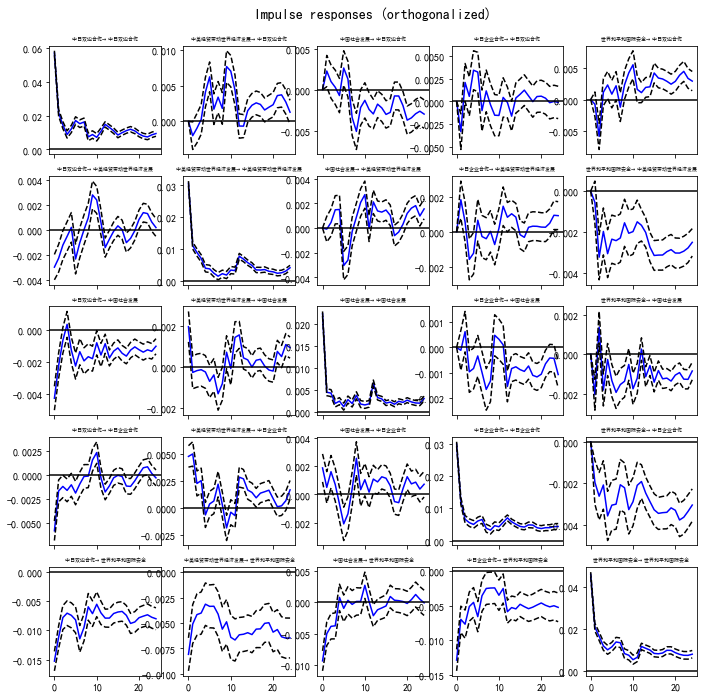

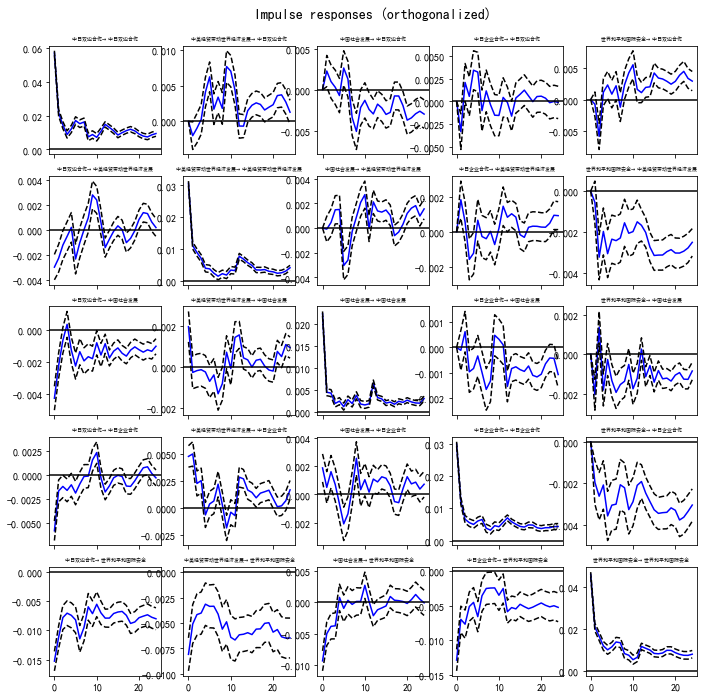

In [105]:
irf.plot(orth=True,signif=.33, subplot_params = {'fontsize' : 5})

# 脉冲响应图note
从图形来判断，所有的25种波动冲击都没有表现出明显收敛趋势，正负两倍标准差的偏离带并没有向脉冲响应靠拢。可以尝试拉长观察的时间来判断后续有无收敛趋势。  
从95%置信区间来判断，有部分冲击在20期之后趋向于0：中美经贸带动世界经济发展对中日双边合作的冲击，中日企业合作对中日双边合作的冲击，中日双边合作对中美经贸带动世界经济发展的冲击，中日企业合作对中美经贸带动世界经济发展的冲击，中日双边合作对中日企业合作的冲击，中国社会发展对世界和平和国际安全的冲击。  
要判断模型的稳定性，可能需要增加观测的期数以观察冲击在更长期的趋势。

In [107]:
plt.savefig('./irf.jpg')

<Figure size 432x288 with 0 Axes>

### 方差图

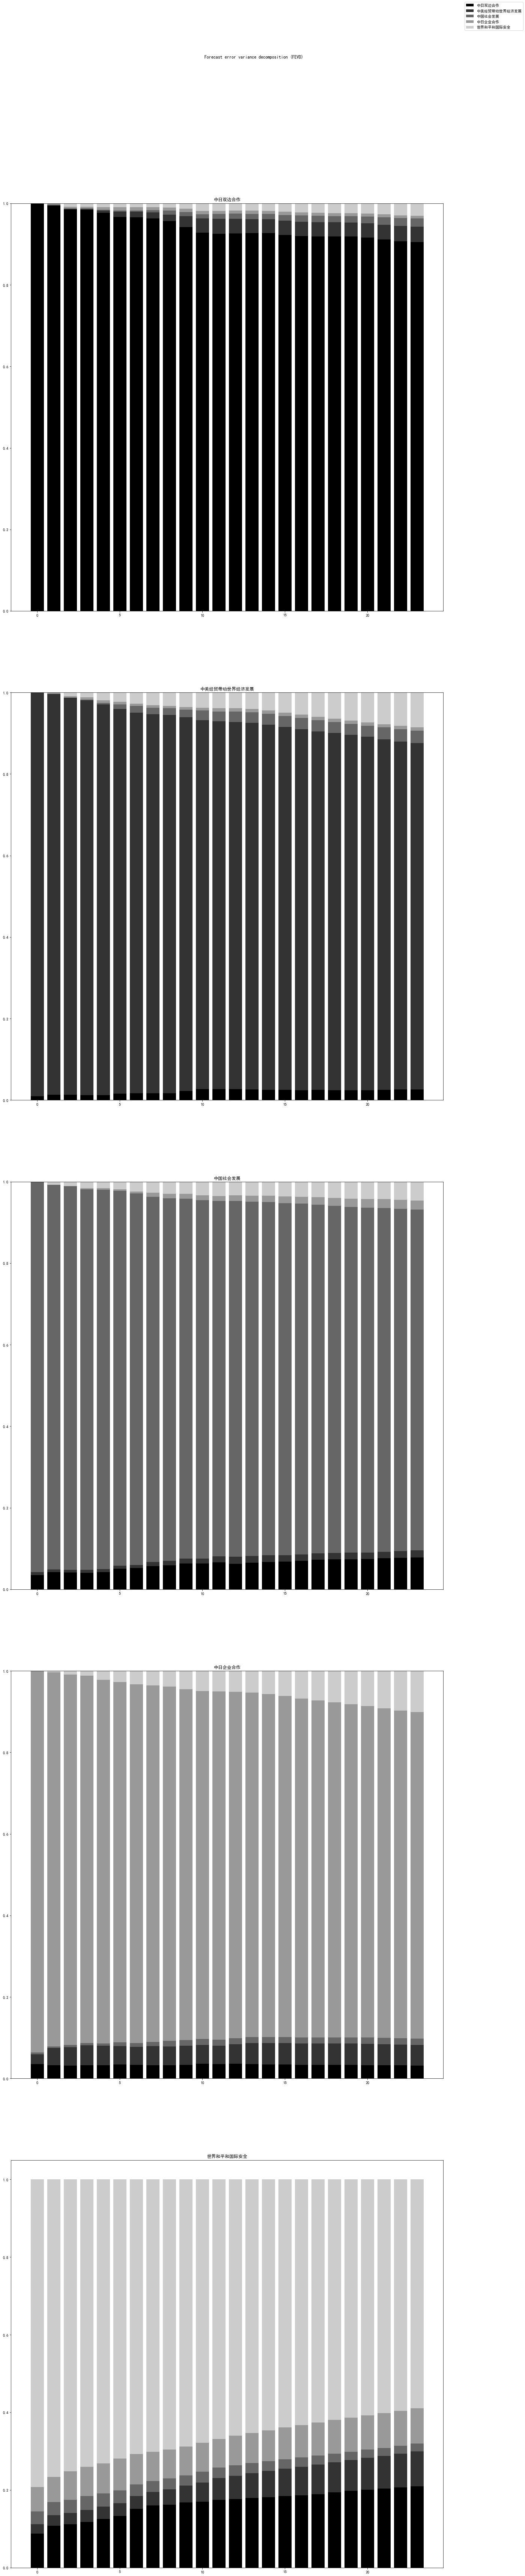

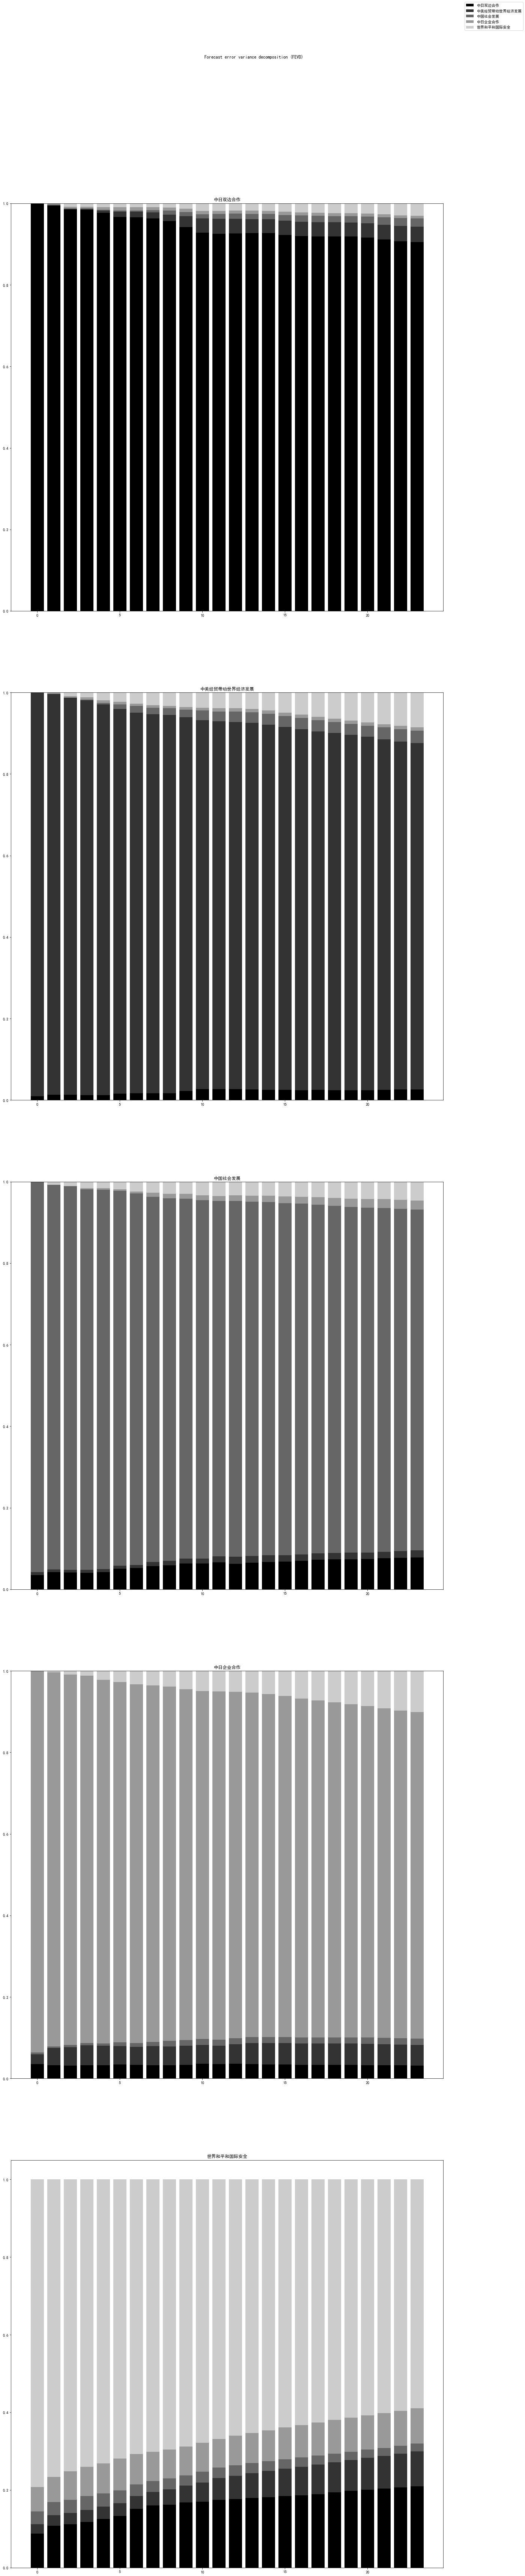

In [106]:
var_mod.fevd(24).plot(figsize=(20,100))

# 方差图note
对于5个主题的变化而言贡献最大的都是自身，且自身的贡献比例虽然会随着时间的推移减小，但一直占据绝对的优势。  
对于中日双边合作，除自身外贡献最大的主题是中美经贸带动世界经济发展。  
对中美经贸带动世界经济发展，除自身外贡献最大的主题是世界和平和国际安全。  
对中国社会发展，除自身外贡献最大的主题是中日双边合作。  
对中日企业合作，除自身外贡献最大的主题是世界和平和国际安全。  
对世界和平和国际安全，除自身外贡献最大的主题是中日双边合作。